In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/C247Project/project/

/content/drive/.shortcut-targets-by-id/1lO_lCKfnzu9fB3MDutIRFUOktcz9B9el/C247Project/project


In [3]:
!pip install tensorflow

In [4]:
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, LSTM, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, ReLU, Reshape, Conv2DTranspose
from tensorflow.keras import backend as UT
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Import Datasets

In [6]:
X_test = np.load("Dataset/X_test.npy")
y_test = np.load("Dataset/y_test.npy")
person_train_valid = np.load("Dataset/person_train_valid.npy")
X_train_valid = np.load("Dataset/X_train_valid.npy")
y_train_valid = np.load("Dataset/y_train_valid.npy")
person_test = np.load("Dataset/person_test.npy")

y_train_valid -= 769
y_test -= 769

##Shape of Data

In [7]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## VAE

In [22]:
## Variables

batch_size = 64
kernel_size = 5
filters_1 = 32
filters_2 = 64
hidden_dim = 2
epochs = 50

X_VAE_train = X_train_valid.reshape(X_train_valid.shape[0], X_train_valid.shape[1], X_train_valid.shape[2], 1).astype('float32')
X_VAE_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1).astype('float32')

input_shape = (batch_size,22,1000,1)
print(input_shape[1:])


(22, 1000, 1)


In [9]:
def sampling(in_1,in_2):

  z_mean = in_1
  z_log_var = in_2
  out = layers.Lambda(sampling_reparameterization)([z_mean, z_log_var])
  return out

def sampling_reparameterization(params):

  z_mean, z_log_var = params
  epsilon = UT.random_normal(shape=UT.shape(z_mean), mean=0., stddev=1.)
  z = z_mean + UT.exp(z_log_var / 2) * epsilon
  return z

In [10]:
def VAE(input_shape):

  ##############
  ## ENCODER ##
  #############

  inputs = keras.Input(shape=input_shape[1:],batch_size=None)
  x = inputs

  #Block1
  x = layers.Conv2D(filters_1,kernel_size=(1,40),strides=(1,20))(x)
  #x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  #Block2
  x = layers.Conv2D(filters_2,kernel_size=(22,1))(x)
  #x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  #shape = 1,49,64
  useful_shape = UT.int_shape(x)

  #Final block
  x = layers.Flatten()(x)
  x = layers.Dense(16,activation='relu')(x)

  z_mean = layers.Dense(hidden_dim)(x)
  z_log_var = layers.Dense(hidden_dim)(x)
  z_log_var += 1e-6 #add a small epsilon so that it's not zero

  ###############
  ## SAMPLING ##
  ##############

  latent = sampling(z_mean, z_log_var)

  ##############
  ## DECODER ##
  #############

  x = latent

  #Initial block
  x = layers.Dense(1*49*64, activation='relu')(x)
  x = layers.Reshape((1,49,64))(x)

  # Block1
  x = layers.Conv2DTranspose(filters_2, kernel_size=(22,1))(x)
  #x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  #Block2
  x = layers.Conv2DTranspose(filters_1, kernel_size=(1,40), strides= (1,20))(x)
  #x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  #Final block
  out = layers.Conv2DTranspose(1, kernel_size=kernel_size, strides=1,padding='same')(x)

  ##############
  #### VAE ####
  #############

  vae = tf.keras.Model(inputs,out,name="vae")
  vae.summary()

  return (vae,inputs,out,z_mean,z_log_var)

## Loss function

In [23]:
def mse_loss(y_true, y_pred):
    r_loss = UT.mean(UT.square(y_true - y_pred), axis = [1,2,3])
    #Multiply it by the time length and the channels
    return 1000 * 22 * r_loss 
 
def kl_loss(mean, log_var):
    kl_loss =  -0.5 * UT.sum(1 + log_var - UT.square(mean) - UT.exp(log_var), axis = -1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, var):
    r_loss = mse_loss(y_true, y_pred)
    k_loss = kl_loss(mean, var)
    return  UT.mean(r_loss + k_loss)

## Training

In [24]:
def train(dataset, epochs):

  vae, inputs, out, mean, log_var = VAE(input_shape)
  loss = vae_loss(inputs, out, mean, log_var)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.1, beta_2=0.999)
  vae.add_loss(loss)
  vae.compile(loss=None, optimizer=optimizer)  
  vae.fit(x=X_VAE_train,y=X_VAE_train,epochs=epochs, batch_size=batch_size,validation_data=(X_VAE_test,None))

  return vae

In [25]:
vae = train(X_VAE_train, epochs)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 22, 1000, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 22, 49, 32)   1312        ['input_16[0][0]']               
                                                                                                  
 leaky_re_lu_60 (LeakyReLU)     (None, 22, 49, 32)   0           ['conv2d_30[0][0]']              
                                                                                                  
 conv2d_31 (Conv2D)             (None, 1, 49, 64)    45120       ['leaky_re_lu_60[0][0]']       

## Hyperparameters tuning

In [18]:
from sklearn.metrics import mean_squared_error

lrs = [0.001,0.0004,0.0006]
bs = [32,64,128]
scores = []

m = tf.keras.metrics.MeanSquaredError()

for lr in lrs:
  for b in bs:

    vae, inputs, out, mean, log_var = VAE(input_shape)
    loss = vae_loss(inputs, out, mean, log_var)
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr,beta_1=0.1, beta_2=0.999)
    vae.add_loss(loss)
    vae.compile(loss=None, optimizer=optimizer)  
    vae.fit(x=X_VAE_train,y=X_VAE_train,epochs=30, batch_size=b,validation_data=(X_VAE_test,None))
    pred = vae.predict(X_VAE_train)
    score = m(X_VAE_train,pred).numpy()
    scores.append((lr,b,score))

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 22, 1000, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 22, 49, 32)   1312        ['input_7[0][0]']                
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)     (None, 22, 49, 32)   0           ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 1, 49, 64)    45120       ['leaky_re_lu_24[0][0]']       

In [29]:
for score in scores:
  print("lr = {",score[0],"} , bs = {",score[1],"} error = {",score[2],"}")

lr = { 0.001 } , bs = { 32 } error = { 109.692055 }
lr = { 0.001 } , bs = { 64 } error = { 110.24325 }
lr = { 0.001 } , bs = { 128 } error = { 109.64966 }
lr = { 0.0004 } , bs = { 32 } error = { 109.61293 }
lr = { 0.0004 } , bs = { 64 } error = { 109.5447 }
lr = { 0.0004 } , bs = { 128 } error = { 109.43475 }
lr = { 0.0006 } , bs = { 32 } error = { 109.564125 }
lr = { 0.0006 } , bs = { 64 } error = { 109.62864 }
lr = { 0.0006 } , bs = { 128 } error = { 109.71559 }


## Generate synthetic data

In [26]:
synthetic_data = vae.predict(X_VAE_train)
print(UT.int_shape(synthetic_data))

(2115, 22, 1000, 1)


## Visualize the new data

(2115, 22, 1000)


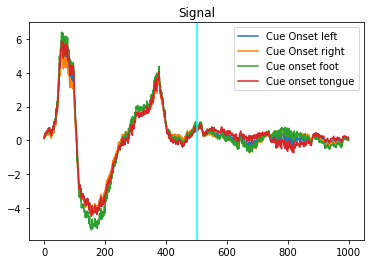

In [30]:
synthetic_data = synthetic_data.reshape(synthetic_data.shape[0],synthetic_data.shape[1],synthetic_data.shape[2])
print(synthetic_data.shape)

#Visualize the data on for channel 8
ch_data = synthetic_data[:,8,:]

#Class 1
class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)

#Class 2
class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

#Class 3
class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

#Class 4
class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')
plt.title("Signal")

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

#NOTE: we use the same labels y_train_valid because we've generated 2115 synthetic data (one-to-one mapping)

## Save the synthetic data in a file

In [28]:
with open('synthetic_data.npy', 'wb') as f:
  np.save(f, synthetic_data)

## Appendix: draft code

In [ ]:
# def encoder(input_encoder):

#   inputs = keras.Input(shape=input_shape[1:])
#   x = inputs

#   #Block1
#   x = layers.Conv2D(32,kernel_size=(1,40),strides=(1,20))(x)
#   x = layers.BatchNormalization()(x)
#   x = layers.LeakyReLU()(x)

#   #Block2
#   x = layers.Conv2D(64,kernel_size=(22,1))(x)
#   x = layers.BatchNormalization()(x)
#   x = layers.LeakyReLU()(x)

#   #shape = 1,49,64
#   useful_shape = UT.int_shape(x)

#   #Final block
#   x = layers.Flatten()(x)
#   x = layers.Dense(16,activation='relu')(x)

#   z_mean = layers.Dense(2)(x)
#   z_log_var = layers.Dense(2)(x)
#   z_log_var += 1e-6 #add an epsilon so that it's not zero


#   model = tf.keras.Model(inputs, (z_mean, z_log_var), name="Encoder")

#   model.summary()

#   return (model, z_mean, z_log_var)

In [ ]:
# def decoder(input_decoder):

#   inputs = keras.Input(shape=(2,))
#   x = inputs

#   #Initial block
#   x = layers.Dense(1*49*64)(x)
#   x = layers.Reshape((1,49,64))(x)

#   # Block1
#   x = layers.Conv2DTranspose(64, kernel_size=(22,1))(x)
#   x = layers.BatchNormalization()(x)
#   x = layers.LeakyReLU()(x)

#   #Block2
#   x = layers.Conv2DTranspose(32, kernel_size=(1,40), strides= (1,20))(x)
#   x = layers.BatchNormalization()(x)
#   x = layers.LeakyReLU()(x)

#   #Final block
#   out = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid')(x)

#   model = tf.keras.Model(inputs, out, name = "Decoder")

#   model.summary()

#   return (model, out)



In [ ]:
# @tf.function
# def train_step(data):

#     with tf.GradientTape() as enc, tf.GradientTape() as dec:
        

#         e, mean, log_var = encoder(data)
#         latent = sampling(mean, log_var)

#         d, generated_data = decoder(latent)

#         generated_data = tf.cast(generated_data, tf.float64)

#         loss = vae_loss(data, generated_data, mean, log_var)
#         print(loss)
       

#     gradients_of_enc = enc.gradient(loss, e.trainable_variables)
#     gradients_of_dec = dec.gradient(loss, d.trainable_variables)
 
#     optimizer.apply_gradients(zip(gradients_of_enc, e.trainable_variables))
#     optimizer.apply_gradients(zip(gradients_of_dec, d.trainable_variables))

#     return loss


In [ ]:
# def train_step(data):
  
#   vae, out, mean, log_var = VAE(data)
#   loss = vae_loss(data, out, mean, log_var)

#   vae.add_loss(loss)
#   vae.compile(optimizer,loss=None)
  
#   return loss

In [ ]:
# def sampling(args):   
#     mean, log_var = args
#     batch = UT.shape(mean)[0]
#     dim = UT.int_shape(mean)[1]
#     epsilon = UT.random_normal(shape=(batch, dim))
#     return mean + UT.exp(0.5 * log_var) * epsilon 

In [ ]:
# ## VAE

# #ENCODER
# inp = Input(shape=inp)
# x = inp
# x = Conv2D(filters=filters_1,kernel_size=(1, 50),strides=(1,25),)(x)
# x = ReLU()(x)
# x = Conv2D(filters=filters_2,kernel_size=(22, 1),)(x)
# x = ReLU()(x)
# print(UT.int_shape(x))
# x = Flatten()(x)
# x = Dense(16, activation='relu')(x)
# print(UT.int_shape(x))
# mean = Dense(hidden_dim)(x)
# log_var = Dense(hidden_dim)(x)

# #SAMPLING
# z = Lambda(sampling, output_shape=(hidden_dim,),)([mean, log_var]) 
# encoder = Model(inp, [mean, log_var, z])

# #DECODER
# dec_inp = Input(shape=(hidden_dim,))
# x = Dense(22 * 9 * 32, activation='relu')(dec_inp)
# x = Reshape((22, 9, 32))(x)
# print(UT.int_shape(x))
# x = Conv2DTranspose(filters=filters_2,kernel_size=(22, 1),activation='relu',)(x)
# x = Conv2DTranspose(filters=filters_1,kernel_size=(1, 50),activation='relu',strides=(1,25))(x)
# out = Conv2DTranspose(filters=1,kernel_size=kernel_size,padding='same',)(x)
# print(UT.int_shape(out))
# decoder = Model(dec_inp, out)

# #VAE
# out = decoder(encoder(inp)[2])
# vae = Model(inp, out)

In [ ]:
# #TRAINING

# r_loss = mse(UT.flatten(inp), UT.flatten(out))
# r_loss *= 22 * 50
# kl_loss = 1 + log_var - UT.square(mean) - UT.exp(log_var)
# kl_loss = UT.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = UT.mean(r_loss + kl_loss)
# vae.add_loss(vae_loss)
# optimizer = Adam(learning_rate=0.001, beta_1=0.1, beta_2=0.999, amsgrad=False)

# vae.compile(optimizer=optimizer, loss=None)

# loss_record = vae.fit(x = X_train_valid,epochs=epochs,batch_size=batch_size,validation_data=(X_test, None))